In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

using gpu 2


In [2]:
#Checking wich GPU is beeing used

!nvidia-smi

Wed Nov 17 13:49:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   26C    P8    17W / 250W |   3066MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   

In [25]:
# #Load data

# #train and test data directory
# data_dir_1 = 'dialogue/Dataset/VoiceDetection/images_medium/images_splitfolders/' #Medium dataset
# data_dir_2 = 'dialogue/Dataset/VoiceDetection/images_hard/images_splitfolders/'   #More difficult dataset

# #load the train and test data
# train_dataset = ImageFolder(data_dir_1 + 'train',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# #Commend if you dont want to use the combination of the two datasets
# train_dataset = train_dataset + ImageFolder(data_dir_2 + 'train',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# test_dataset = ImageFolder(data_dir_1 + 'test',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# #Commend if you dont want to use the combination of the two datasets
# test_dataset = test_dataset + ImageFolder(data_dir_2 + 'test',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# val_dataset = ImageFolder(data_dir_1 + 'val',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# #Commend if you dont want to use the combination of the two datasets
# val_dataset = val_dataset + ImageFolder(data_dir_2 + 'val',transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))
# #train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)#train_set is made into a dataloader, shuffled
# #test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

# print(len(train_dataset))
# print(len(test_dataset))
# print(len(test_dataset)/len(test_dataset+train_dataset))

3680
460
0.1111111111111111


In [25]:
#Load data
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_temp = pd.DataFrame(data)
df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data)

                                                   data  isSpeaking
0     [9.43420124053955, 18.539894104003906, 48.5989...       False
1     [0.988338053226471, 56.69844436645508, 196.634...       False
2     [81.51625061035156, 74.42724609375, 219.707489...       False
3     [51.16434097290039, 88.26544952392578, 112.086...       False
4     [627.1080932617188, 546.4993896484375, 261.254...       False
...                                                 ...         ...
2295  [0.005173461511731148, 0.0019029141403734684, ...        True
2296  [0.012229980900883675, 0.005093342624604702, 0...        True
2297  [0.00039877192466519773, 0.0004614321514964103...       False
2298  [0.0036343743558973074, 0.001358666573651135, ...       False
2299  [0.018530111759901047, 0.006890260148793459, 0...       False

[2300 rows x 2 columns]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_data['data'], df_data['isSpeaking'], test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
print(X_train)

<class 'pandas.core.series.Series'>
1491    [0.009870889596641064, 0.0023517808876931667, ...
1669    [4.2443185520824045e-05, 0.0003900589945260435...
697     [11.51391315460205, 26.32008171081543, 14.2846...
390     [0.0997493714094162, 0.1607533097267151, 0.091...
610     [1.4053372144699097, 0.4480704963207245, 0.851...
                              ...                        
1786    [1.235846757888794, 0.3133677840232849, 0.0004...
756     [0.006534569431096315, 0.0050957780331373215, ...
790     [0.6982523202896118, 0.818035364151001, 0.4700...
2025    [0.00026319504831917584, 0.0008301478228531778...
1417    [0.025680650025606155, 0.007223902270197868, 0...
Name: data, Length: 1472, dtype: object


In [37]:
X_train = torch.tensor(X_train.values)
y_train = torch.tensor(y_train.values)
#X_test = torch.from_numpy(test_X).values()
print(X_train.shape, y_train.shape)
#print(test_X.shape)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [28]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Test Data : {len(test_dataset)}")

#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 3680
Length of Test Data : 460


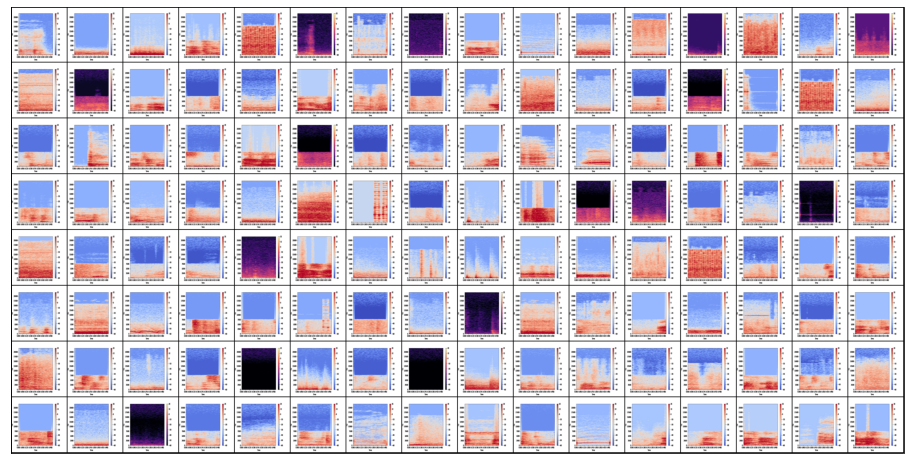

In [29]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [30]:
plt.close()

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
class CNN_model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        nn.Sigmoid()
        return self.network(xb)

In [33]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [35]:
model = CNN_model()
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [36]:
model = to_device(CNN_model(),device)

evaluate(model,val_dl)
num_epochs = 150
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1463, val_loss: 1.0292, val_acc: 0.5183
Epoch [1], train_loss: 1.0416, val_loss: 1.0199, val_acc: 0.5183
Epoch [2], train_loss: 1.0378, val_loss: 1.0191, val_acc: 0.5183
Epoch [3], train_loss: 1.0273, val_loss: 1.0074, val_acc: 0.5183
Epoch [4], train_loss: 1.0097, val_loss: 0.9244, val_acc: 0.5193
Epoch [5], train_loss: 0.9432, val_loss: 0.8927, val_acc: 0.5329
Epoch [6], train_loss: 0.9016, val_loss: 0.8597, val_acc: 0.5441
Epoch [7], train_loss: 0.8548, val_loss: 0.8498, val_acc: 0.5747
Epoch [8], train_loss: 0.8551, val_loss: 0.8157, val_acc: 0.5782
Epoch [9], train_loss: 0.7985, val_loss: 0.7728, val_acc: 0.6090
Epoch [10], train_loss: 0.7567, val_loss: 0.6947, val_acc: 0.6496
Epoch [11], train_loss: 0.7957, val_loss: 0.7088, val_acc: 0.6315
Epoch [12], train_loss: 0.6789, val_loss: 0.6309, val_acc: 0.6901
Epoch [13], train_loss: 0.6624, val_loss: 0.6217, val_acc: 0.6899
Epoch [14], train_loss: 0.6103, val_loss: 0.6983, val_acc: 0.6385
Epoch [15], train_lo

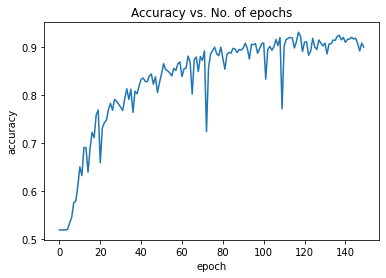

In [40]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

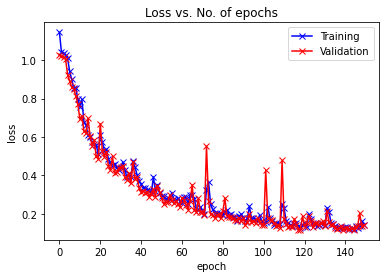

In [38]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [39]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(val_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.9642224311828613, 'val_acc': 0.80078125}

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    print(type(img))
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_dataset.classes[preds[0].item()]

In [ ]:
from PIL import Image

#open image file
img = Image.open("dialogue/Dataset/VoiceDetection/images/images_splitfolders/val/True/1113_True_dataset_with_negatives_spectro.png")

img = img.convert('RGB')
print(type(img))
print(img)
#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

FileNotFoundError: [Errno 2] No such file or directory: 'dialogue/Dataset/VoiceDetection/images/images_splitfolders/val/True/1113_True_dataset_with_negatives_spectro.png'

In [ ]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
